In [2]:
### Load relevant packages

import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import matplotlib              as mpl
import seaborn                 as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# This statement allow to display plots without asking to
%matplotlib inline

# you can also add the following line for making pretty-loking plots
plt.style.use('ggplot')

# Gradient Boosting with Imputed Data

In [3]:
# Load and Prepare Data: we use imputed data
df_imp = pd.read_csv('../../data/processed/ckd_imputed.csv')
df_imp['status'] = df_imp['status'].map({'ckd': 1, 'notckd': 0})
df_imp = df_imp[['hemo', 'sg', 'sc', 'rbcc', 'pcv', 'htn', 'dm', 'bp', 'age', 'status']]


X = df_imp.drop(columns=['status'])
y = df_imp['status']

# Split into Training (80%) and Test (20%)
# 'stratify' ensures both sets have the same percentage of CKD vs NotCKD
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [20]:
df_imp

,hemo,sg,sc,rbcc,pcv,htn,dm,bp,age,status
0,15.4,3,1.2,5.200000,44.0,1.0,1.0,80.0,48.0,1
1,11.3,3,0.8,4.277045,38.0,0.0,0.0,50.0,7.0,1
2,9.6,1,1.8,3.725814,31.0,0.0,1.0,80.0,62.0,1
3,11.2,0,3.8,3.900000,32.0,1.0,0.0,70.0,48.0,1
4,11.6,1,1.4,4.600000,35.0,0.0,0.0,80.0,51.0,1
...,...,...,...,...,...,...,...,...,...,...
395,15.7,3,0.5,4.900000,47.0,0.0,0.0,80.0,55.0,0
396,16.5,4,1.2,6.200000,54.0,0.0,0.0,70.0,42.0,0
397,15.8,3,0.6,5.400000,49.0,0.0,0.0,80.0,12.0,0
398,14.2,4,1.0,5.900000,51.0,0.0,0.0,60.0,17.0,0


In [4]:
# Run Grid Search on the Training Set ONLY
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='f1',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


              precision    recall  f1-score   support

         ckd       1.00      0.97      0.98        30
      notckd       0.98      1.00      0.99        50

    accuracy                           0.99        80
   macro avg       0.99      0.98      0.99        80
weighted avg       0.99      0.99      0.99        80



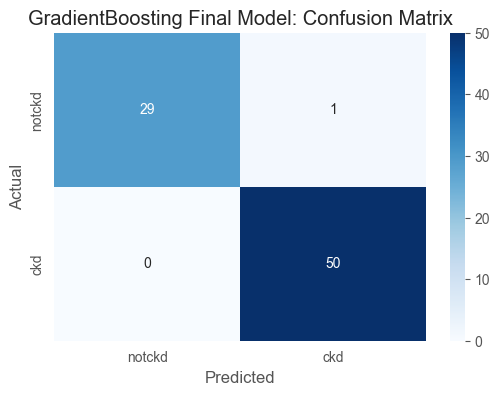

In [5]:
# Final Evaluation on the Unseen Test Set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['notckd', 'ckd'], yticklabels=['notckd', 'ckd'])
plt.title('GradientBoosting Final Model: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
#print(f"Final Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=['ckd', 'notckd']))

# Saving the model for using in the frontend

In [6]:
# 1. Get the best parameters from your previous search
best_params = grid_search.best_params_

# 2. Combine the data
X_all = pd.concat([X_train, X_test], axis=0)
y_all = pd.concat([y_train, y_test], axis=0)

# 3. Create a new model with the best parameters and fit on ALL data
final_production_model = GradientBoostingClassifier(**best_params)
final_production_model.fit(X_all, y_all)

,"loss loss: {'log_loss', 'exponential'}, default='log_loss'The loss function to be optimized. 'log_loss' refers to binomial andmultinomial deviance, the same as used in logistic regression.It is a good choice for classification with probabilistic outputs.For loss 'exponential', gradient boosting recovers the AdaBoost algorithm.",'log_loss'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.For an example of the effects of this parameter and its interaction with``subsample``, see:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_regularization.py`.",0.01
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",100
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",0.8
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are'friedman_mse' for the mean squared error with improvement score byFriedman, 'squared_error' for mean squared error. The default value of'friedman_mse' is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``,

In [7]:
# 4. Save this new model
import joblib
joblib.dump(final_production_model, '../../models/ckd_final_model_full_data_gradient_boosting.pkl')

['../../models/ckd_final_model_full_data_gradient_boosting.pkl']

# Predict with new data using the model saved

In [11]:
X_all.head()

,hemo,sg,sc,rbcc,pcv,htn,dm,bp,age
108,11.800000,2,1.000000,4.200000,37.000000,0.0,0.0,80.0,45.0
210,7.300000,2,12.800000,3.900000,20.000000,1.0,1.0,100.0,59.0
137,10.000000,1,4.000000,3.695806,29.000000,1.0,1.0,60.0,45.0
148,11.218535,2,1.034864,4.068202,32.004361,1.0,0.0,60.0,69.0
246,8.600000,2,15.200000,2.500000,26.000000,1.0,0.0,110.0,48.0


In [13]:
y_all.head()

108    1
210    1
137    1
148    1
246    1
Name: status, dtype: int64

In [12]:
# Load the model from the file
loaded_model = joblib.load('../../models/ckd_final_model_full_data_gradient_boosting.pkl')

# The new data must contain the same order in their columns as the dataset
# used for training it
new_data = {
    'hemo' : [10.34],
    'sg' : [2],
    'sc' : [10.34],
    'rbcc' : [10.34],
    'pcv' : [32.01],
    'htn' : [0],
    'dm' : [1],
    'bp' : [67],
    'age' : [22],
}

# Create a DataFrame
new_data_df = pd.DataFrame(new_data)

# Predict
prediction = loaded_model.predict(new_data_df)
probability = loaded_model.predict_proba(new_data_df)

# Output results
print(f"Predicted Class: {prediction[0]}")
print(f"Confidence (Probability): {probability[0][prediction[0]]:.2%}")

if prediction[0] == 1: # Assuming 1 is CKD based on your previous target_names
    print("Result: The model predicts CKD.")
else:
    print("Result: The model predicts NO CKD.")



Predicted Class: 1
Confidence (Probability): 82.82%
Result: The model predicts CKD.
